In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import importlib

import itertools as it
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import statsmodels.api as sm

from itertools import product
from sklearn.pipeline import make_pipeline

from criteriaetl.utils.expansion_func import (get_value_counts_with_expansion_factor,
    get_percentage_table_with_expansion_factor)
from criteriaetl.utils.display_func import cdisplay, percentage_count_plot
from criteriaetl.utils.common_func import (get_weighted_complete_randomization_series_on_subset, 
    proportional_cut, weighted_qcut, get_partition_bool_columns_dict)
from criteriaetl.transformers.columns_base import (NameTransformer, 
    ReplaceTransformer, SelectTransformer, AssignTransformer)
from criteriaetl.transformers.rows_base import AggregateTransformer
from criteriaetl.transformers.fusion_base import MergeTransformer

from projectetl.utils.dataload import (load_survey_data_do, save_survey_with_pickle,
                                       load_survey_from_pickle)
from projectetl.utils.config import (ENCFT_SURVEY_PATH, ENCFT_PREVIOUS_SURVEY_PATH,
                                     ENCFT_OBJECT_DIR, INFLATION_OBJECT_DIR, DATA_DIR)

## Configuration variables

In [3]:
get_raw = 0 # if 1 will read the raw data, if 0 will load the data from a previously serialized pickle object
year = 2020 # year we want to analyze
month = 6 # month to analyze
trimester = 2 # trimester of the year we want to analyze

# Load data

## Survey


In [4]:
if get_raw:
    survey_raw = load_survey_data_do(ENCFT_SURVEY_PATH)
    save_survey_with_pickle(survey_raw, ENCFT_OBJECT_DIR / 'encft202001-202004.pkl')
else:
    survey_raw = load_survey_from_pickle(ENCFT_OBJECT_DIR / 'encft202001-202004.pkl')

In [5]:
survey_household_raw = survey_raw['Hogar']
survey_member_raw = survey_raw['Miembros']
survey_house_raw = survey_raw['Vivienda']

### Split surveys by trimester

In [6]:
survey_household_raw['periodo'].value_counts()

202001    2268
202002    2242
202007    2030
202010    1990
202008    1981
202011    1944
202009    1928
202012    1859
202004    1823
202005    1787
202006    1749
202003    1738
Name: periodo, dtype: int64

In [7]:
survey_household_raw['trimestre'].value_counts()

20201    6248
20203    5939
20204    5793
20202    5359
Name: trimestre, dtype: int64

In [8]:
def split_survey_by(survey, column_name, values):
    return tuple(survey[survey[column_name] == value] for value in values)

In [9]:
# split constants
column_name = 'trimestre'
values = [20201, 20202, 20203, 20204]

In [10]:
# split household surveys
survey_household_raw_01, survey_household_raw_02, \
    survey_household_raw_03, survey_household_raw_04 = split_survey_by(survey_household_raw,
                                                                       column_name,
                                                                       values)

In [11]:
# split member surveys
survey_member_raw_01, survey_member_raw_02, \
    survey_member_raw_03, survey_member_raw_04 = split_survey_by(survey_member_raw,
                                                                 column_name,
                                                                 values)

In [12]:
# split house surveys
survey_house_raw_01, survey_house_raw_02, \
    survey_house_raw_03, survey_house_raw_04 = split_survey_by(survey_house_raw,
                                                               column_name,
                                                               values)

## Dictionary

In [13]:
survey_dict = survey_raw['Diccionario']

In [14]:
def consult_dict(field):
    return survey_dict[survey_dict['campo'] == field.upper()][['valor', 'descripcion', 'texto']] 

## Exchange Rate

In [15]:
exchange_rate = survey_raw['Tasa monedas']
exchange_rate.head()

,periodo,moneda,tasa_a_dolar_mes1,tasa_a_dolar_mes2,tasa_a_dolar_mes3,tasa_a_dolar_mes4,tasa_a_dolar_mes5,tasa_a_dolar_mes6,tasa_a_dolar_promedio,tasa_a_pesos_mes1,tasa_a_pesos_mes2,tasa_a_pesos_mes3,tasa_a_pesos_mes4,tasa_a_pesos_mes5,tasa_a_pesos_mes6,tasa_a_pesos_promedio
0,202001,CHF,0.99,0.98,0.99,0.99,0.99,0.98,0.99,51.32,52.10,52.05,53.15,53.29,53.92,52.64
1,202001,DOP,50.81,51.06,51.53,52.62,52.76,52.84,51.94,1.00,1.00,1.00,1.00,1.00,1.00,1.00
2,202001,EUR,0.89,0.90,0.91,0.90,0.91,0.90,0.90,57.09,56.73,56.63,58.47,57.98,58.71,57.60
3,202001,USD,1.00,1.00,1.00,1.00,1.00,1.00,1.00,50.81,51.06,51.53,52.62,52.76,52.84,51.94
4,202002,DOP,51.06,51.53,52.62,52.76,52.84,53.04,52.31,1.00,1.00,1.00,1.00,1.00,1.00,1.00


## Inflation

In [16]:
inflation_df = load_survey_from_pickle(INFLATION_OBJECT_DIR / 'inflation_basket_2016.pkl')
inflation_df.head()

,alimentaria,no_alimentaria,ampliada
date,,,
2016-01-01,1.043013,0.984132,0.988909
2016-02-01,1.022986,0.985364,0.988446
2016-03-01,1.011455,0.987945,0.989883
2016-04-01,1.002352,0.988627,0.989763
2016-05-01,0.998407,0.991860,0.992404


## Current Survey

In [17]:
survey_member_raw = locals().get(f'survey_member_raw_0{trimester}')
survey_house_raw = locals().get(f'survey_house_raw_0{trimester}')
survey_household_raw = locals().get(f'survey_household_raw_0{trimester}')


# Processing Members
... missing docs

## Replace Transformer

In [18]:
replace_member_map = {
    'sexo': {
        1: 0,
        2: 1
    }
}

replace_member_transformer = ReplaceTransformer(replace_member_map)
survey_member_replaced = replace_member_transformer.transform(survey_member_raw)

## Assign Transformer

In [19]:
total_income_cols = {
    'ingreso_laboral_monetario': [
        'ingreso_asalariado', # Ingreso monetario principal mensual por ocupacion principal para asalariados (OK)
        # '', # Ingreso monetario mensual por ocupacion secundaria para cuenta propia o patron
        'comisiones', # Ingreso monetario mensual de comisiones por ocupacion principal (OK)
        'propinas', # Ingreso monetario mensual de propinas por ocupacion principal (OK)
        'horas_extra', # Ingreso monetario mensual de horas extras por ocupacion principal (OK)
        'especie_alimentos', # Ingreso en especie por alimentos adicional mensual por ocupacion principal (OK)
        'especie_vivienda', # Ingreso en especie por pago de viviendas adicional mensual por ocupacion principal (OK)
        'especie_transporte', # Ingreso en especie por pago de transporte adicional mensual por ocupacion principal (OK)
        'especie_combustible', # Ingreso en especie por pago de combustible mensual por ocupacion principal (OK)
        'especie_celular', # Ingreso en especie por pago de celular adicional mensual por ocupacion principal (OK)
        'ingreso_asalariado_secun', # Ingreso monetario mensual por ocupacion secundaria para ocupacion secundaria asalariada
        'ingreso_independientes', # Ingreso monetario principal mensual por ocupacion principal para cuenta propia o patron (OK)
        'otros_pagos_secun', # Ingreso monetario mensual de otros ingresos monetarios mensuales por ocupación secundaria asalariada
        'otros_beneficios_secun', # Ingreso monetario mensual de otros ingresos por beneficios marginales anuales en ocupación secundaria asalariada

        # no se deflactan
        # '', # Ingreso monetario mensual de vacaciones pagadas por ocupacion principal
        # '', # Ingreso monetario mensual de dividendos por ocupacion principal
        # '', # Ingreso monetario mensual de bonificacion por ocupacion principal
        # '', # Ingreso monetario mensual de regalia pascual por ocupacion principal
        # '', # Ingreso monetario mensual de utilidades empresariales por ocupacion principal
        # '', # Ingreso monetario mensual de beneficios marginales por ocupacion principal
        # '', # Ingreso monetario nacional no laboral por pension adicional

        # se deflactan con el promedio del IPC de los últimos 6 meses
        # 'ingreso_independientes', # Ingreso monetario principal mensual por ocupacion principal para independientes agropecuarios y contratista
        # '', # Ingreso monetario mensual por ocupacion secundaria para independientes agropecuarios y contratista (1 y 2)
    ],

    'ingreso_laboral_no_monetario': [
        'otros_especie', # Ingreso en especie por otros pagos adicional mensual por ocupacion principal
        'especie_independientes', # Ingreso en especie laboral trabajadores por ocupacion principal cuenta propia
        'especie_independientes_secun', # Ingreso en especie laboral trabajadores por ocupacion secundaria cuenta propia
        'pago_especie_secun', # Ingreso monetario mensual de ingresos en especie mensuales por ocupacion secundaria asalariada
    ],
    
    'ingreso_no_laboral_monetario': [
        # no se deflactan
        'interes_nac', # Ingreso monetario nacional no laboral por intereses adicionales
        'alquiler_nac_a', # Ingreso monetario nacional no laboral por alquileres adcionales
        'remesas_nac_a', # Ingreso monetario nacional no laboral por remesas nacionales
        'ayuda_especie_nac_a', # Ingreso en especie no laboral por ayuda de familiares, no familiares e instituciones (AYUDA_ESPECIE_NAC_MONTO, AYUDA_ESPECIE_NAC_ANO_MONTO)

        'pension_nac_a', # Ingreso monetario no laboral por pension o jubilacion
        # '', # Ingreso monetario no laboral por Intereses o dividendos
        # '', # Ingreso monetario no laboral por alquileres o rentas de propiedades
        # '', # Ingreso monetario no laboral por remesas nacionales       
    ],

    'ingreso_no_laboral_no_monetario': [
        # '', # Ingreso en especie no laboral por ayuda de familiares, no familiares e instituciones (otro)
        'consumo_bienes', # Ingreso por autoconsumo y autosuministro para trabajadores por cuenta propia, ocupacion principal (CONSUMIO_BIENES_IN_MONTO)
        'consumo_bienes_secun', # Ingreso por autoconsumo y autosuministro ocupacion secundaria para trabajadores por cuenta propia (CONSUMIO_BIENES_IS_MONTO)
    ],

    'ingreso_monetario_exterior': [
        'pension_ext_1', # Ingresos mensuales externos por pension
        'interes_ext_1', # Ingresos mensuales externos por intereses o dividendos en RD$
        'alquiler_ext_1', # Ingresos mensuales externos por alquileres en RD$
        'regalos_ext_1', # Ingresos externos por regalos
        'remesas_ext', # Ingresos externos por remesas
    ],

    'ingreso_subsidios': [
        # Ingreso monetario no laboral por ayuda del gobierno
        # Prosoli
        'comer_es_primero', 'inc_asistencia_escolar', 'bonoluz',
        'bonogas_hogar', 'proteccion_vejez',
        # Otros
        'bonogas_chofer', 'bono_estudiante_progreso', 'inc_educacion_superior',
        'inc_policia_preventiva', 'inc_marina_guerra'
    ],

    'ingreso_subsidios_covid': [
        'quedate_en_casa', 'fase', 'pa_ti'
    ],

    'ingreso_sin_subsidios_covid': [
        'ingreso_laboral_monetario', 'ingreso_laboral_no_monetario',
        'ingreso_no_laboral_monetario', 'ingreso_no_laboral_no_monetario',
        'ingreso_monetario_exterior', 'ingreso_subsidios'
    ],

    'ingreso_sin_qec': [
        'ingreso_sin_subsidios_covid', 'fase', 'pa_ti'
    ],

    'ingreso_total': [
        'ingreso_sin_subsidios_covid', 'ingreso_subsidios_covid'
    ]
}

In [20]:
assign_member_map = {
    **{
        income_column_name: lambda df, cols=income_sum_columns: df[cols].sum(1)
        for income_column_name, income_sum_columns in total_income_cols.items()
    },
    # Segmentation
    'edad_menor_5': lambda df: (df['edad'] < 5).astype(int),
    'edad_mayor_60': lambda df: (df['edad'] > 60).astype(int),
    'edad_mayor_65': lambda df: (df['edad'] > 65).astype(int),
    'edad_5_a_10': lambda df: ((df['edad'] >= 5) & (df['edad'] < 10)).astype(int),
    'edad_10_a_15': lambda df: ((df['edad'] > 10) & (df['edad'] <= 15)).astype(int),
    # ---
    'es_jefe': lambda df: (df['parentesco'] == 1).astype(int),
    'es_conyugue': lambda df: (df['parentesco'] == 2).astype(int),
    'es_hijo': lambda df: (df['parentesco'] == 3).astype(int),
    'otro_pariente': lambda df: df['parentesco'].isin(range(4, 12)).astype(int),
    'no_pariente': lambda df: (df['parentesco'] == 12).astype(int),
    'sexo_jefe_familia': lambda df: df['sexo'] * df['es_jefe'],
    # ---
    'es_trabajador_domestico': lambda df: df['orden_sector'] == 3,
    'es_enfermo': lambda df: df['motivo_no_disponible'] == 4,
    'es_trabajador_infantil': lambda df: df['edad'].isin(range(0, 16)) & df['trabajo_semana_pasada'] == 1,
    # ---
    'es_informal': lambda df: df['orden_empleo'] == 2,
    'es_formal': lambda df: df['orden_empleo'] == 1
}
assign_member_transformer = AssignTransformer(assign_member_map)
survey_member_assigned = assign_member_transformer.transform(survey_member_replaced)

In [21]:
survey_member_assigned[survey_member_assigned['id_hogar'] == 6006][['edad_menor_5', 'edad_mayor_60']]

,edad_menor_5,edad_mayor_60
19386,0,0
19387,0,0
19388,0,0
19389,0,0
19390,0,0


## Aggregate Transformer

In [22]:
aggregate_member_map = {
    'sum': [
        'quedate_en_casa', 'ingreso_total', 'ingreso_subsidios',
        'ingreso_monetario_exterior', 'ingreso_no_laboral_no_monetario',
        'ingreso_no_laboral_monetario', 'ingreso_laboral_no_monetario',
        'ingreso_laboral_monetario', 'ingreso_subsidios_covid',
        'ingreso_sin_subsidios_covid', 'ingreso_sin_qec',
        'quedate_en_casa', 'comer_es_primero',
        'sexo_jefe_familia', 'edad_menor_5', 'edad_mayor_60',
        'es_jefe', 'es_conyugue', 'es_hijo', 'otro_pariente',
        'no_pariente', 'es_informal', 'es_formal'
    ],

    'any': [
        'edad_menor_5', 'edad_mayor_60', 'edad_mayor_65',
        'edad_5_a_10', 'edad_10_a_15', 'es_trabajador_domestico',
        'es_enfermo', 'es_informal', 'es_trabajador_infantil'
    ],
}
keep_first = ['factor_expansion', 'miembro', 'cantidad_miembros_hogar', 'zona', 'grupo_region']
key = 'id_hogar'
aggregate_member_transformer = AggregateTransformer(aggregate_member_map, keep_first, key)
survey_household_member_aggregated = aggregate_member_transformer.transform(survey_member_assigned)

# Processing Households

## Merge Transformer

In [23]:
merge_survey_household_member_transformer = MergeTransformer(lambda : survey_household_raw, {'by': key})
survey_household_merged = merge_survey_household_member_transformer.transform(survey_household_member_aggregated)

In [24]:
survey_household_merged.head(100)

,id_hogar,factor_expansion_first,miembro_first,cantidad_miembros_hogar_first,zona_first,grupo_region_first,quedate_en_casa_sum,ingreso_total_sum,ingreso_subsidios_sum,ingreso_monetario_exterior_sum,...,incentivo_educacion_superior,bono_escolar_estudiante_prog,prog_incentivo_policia_prev,prog_incentivo_alist_marina,programa_quedate_casa,fondo_asistencia_solidaria_emp,programa_apoyo_trabajadores_in,cantidad_miembros_hogar,hay_recien_nacidos,numero_linea_informante
0,1007,654.403718,1,1,1,Gran Santo Domingo,0,40000.0,0,0.0,...,2,2,2,2,2.0,2.0,2.0,1,2,1
1,2006,654.403718,1,3,1,Gran Santo Domingo,0,44155.0,0,0.0,...,2,2,2,2,2.0,2.0,2.0,3,2,1
2,3008,654.403718,1,3,1,Gran Santo Domingo,0,14272.0,1672,0.0,...,2,2,2,2,1.0,2.0,2.0,3,2,1
3,6006,654.403718,1,5,1,Gran Santo Domingo,0,10053.0,1053,0.0,...,2,2,2,2,1.0,2.0,2.0,5,2,1
4,7006,654.403718,1,4,1,Gran Santo Domingo,0,2550.0,0,0.0,...,2,2,2,2,2.0,2.0,2.0,4,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,191006,1636.009296,1,4,1,Gran Santo Domingo,0,20000.0,0,0.0,...,2,2,2,2,2.0,2.0,2.0,4,2,2
96,193005,1636.009296,1,5,1,Gran Santo Domingo,0,18000.0,0,0.0,...,2,2,2,2,2.0,2.0,2.0,5,2,2
97,195004,1636.009296,1,4,1,Gran Santo Domingo,0,27353.0,1053,0.0,...,2,2,2,2,1.0,2.0,2.0,4,2,2
98,201007,1636.009296,2,2,1,Gran Santo Domingo,0,15000.0,0,3000.0,...,2,2,2,2,2.0,2.0,2.0,2,2,2


## Replace Transformer

In [25]:
household_replace_map = {
    'zona_first': {
        1: 0, # urbana
        2: 1 # rural
    }
}
household_replace_transformer = ReplaceTransformer(household_replace_map)
survey_household_replaced = household_replace_transformer.transform(survey_household_merged)

## Select Transformer

In [26]:
estrato_region_map = {
    'DISTRITO NACIONAL': 'Región Ozama',
    'SANTO DOMINGO URBANO': 'Región Ozama',
    'SANTO DOMINGO RURAL': 'Región Ozama',
    'SANTIAGO URBANO': 'Región Cibao Norte',
    'SANTIAGO RURAL': 'Región Cibao Norte',
    'RESTO CIBAO NORTE URBANO': 'Región Cibao Norte',
    'RESTO CIBAO NORTE RURAL': 'Región Cibao Norte',
    'CIBAO SUR URBANO': 'Región Cibao Sur',
    'CIBAO SUR RURAL': 'Región Cibao Sur',
    ' CIBAO NORDESTE URBANO': 'Región Cibao Nordeste',
    ' CIBAO NORDESTE RURAL': 'Región Cibao Nordeste',
    ' CIBAO NOROESTE URBANO': 'Región Cibao Noroeste',
    ' CIBAO NOROESTE RURAL': 'Región Cibao Noroeste',
    ' VALDESIA URBANO': 'Región Valdesia',
    ' VALDESIA RURAL': 'Región Valdesia',
    ' EL VALLE URBANO': 'Región El Valle',
    ' EL VALLE RURAL': 'Región El Valle',
    ' ENRIQUILLO URBANO': 'Región Enriquillo',
    ' ENRIQUILLO RURAL': 'Región Enriquillo',
    ' HIGUAMO URBANO': 'Región Higuamo',
    ' HIGUAMO RURAL': 'Región Higuamo',
    ' YUMA URBANO': 'Región Yuma',
    ' YUMA RURAL': 'Región Yuma'
}

In [27]:
select_household_map = {
    'region': {
        lambda df, estrato=estrato: df['des_estrato'] == estrato:
            lambda df, region=region: region
        for estrato, region in estrato_region_map.items()
    },

    'tipo_hogar': {
        lambda df: (df['es_jefe_sum'] == 1) & (
            df['es_conyugue_sum'] == 0) & (df['es_hijo_sum'] == 0) & (
            df['otro_pariente_sum'] == 0) & (df['no_pariente_sum'] == 0): "Unipersonal",
        lambda df: (df['es_jefe_sum'] == 1) & (
            df['es_conyugue_sum'] != 0) & (df['es_hijo_sum'] == 0) & (
            df['otro_pariente_sum'] == 0) & (df['no_pariente_sum'] == 0): "Nuclear sin hijos",
        lambda df: (df['es_jefe_sum'] == 1) & (
            df['es_conyugue_sum'] != 0) & (df['es_hijo_sum'] != 0) & (
            df['otro_pariente_sum'] == 0) & (df['no_pariente_sum'] == 0): "Nuclear con hijos",
        lambda df: (df['es_jefe_sum'] == 1) & (
            df['es_conyugue_sum'] == 0) & (df['es_hijo_sum'] != 0) & (
            df['otro_pariente_sum'] == 0) & (df['no_pariente_sum'] == 0): "Nuclear monoparental",
        lambda df: (df['es_jefe_sum'] == 1) & (df['es_conyugue_sum'] != 0)
            & (df['es_hijo_sum'] == 0) & (df['otro_pariente_sum'] != 0)
            & (df['no_pariente_sum'] == 0): "Extendido base nuclear sin hijos",
        lambda df: (df['es_jefe_sum'] == 1) & (df['es_conyugue_sum'] != 0) & (
            df['es_hijo_sum'] != 0) & (df['otro_pariente_sum'] != 0) & (
            df['no_pariente_sum'] == 0): "Extendido base nuclear con hijos",
        lambda df: (df['es_jefe_sum'] == 1) & (
            df['es_conyugue_sum'] == 0) & (df['es_hijo_sum'] != 0) & (
            df['otro_pariente_sum'] != 0) & (df['no_pariente_sum'] == 0): "Extendido base monoparental",
        lambda df: (df['es_jefe_sum'] == 1) & (
            df['es_conyugue_sum'] == 0) & (df['es_hijo_sum'] == 0) & (
            df['otro_pariente_sum'] != 0) & (df['no_pariente_sum'] == 0): "Extendido sin base nuclear",
        lambda df: (df['es_jefe_sum'] == 1) & (df['no_pariente_sum'] != 0): "Compuesto",
    },

    'informalidad_mayoria': {
        lambda df: df['es_informal_sum'] > df['es_formal_sum'] : True,
        'default': False
    }
}

select_household_transformer = SelectTransformer(select_household_map)
survey_household_selected = select_household_transformer.transform(survey_household_replaced)

In [28]:
survey_household_selected

,id_hogar,factor_expansion_first,miembro_first,cantidad_miembros_hogar_first,zona_first,grupo_region_first,quedate_en_casa_sum,ingreso_total_sum,ingreso_subsidios_sum,ingreso_monetario_exterior_sum,...,prog_incentivo_alist_marina,programa_quedate_casa,fondo_asistencia_solidaria_emp,programa_apoyo_trabajadores_in,cantidad_miembros_hogar,hay_recien_nacidos,numero_linea_informante,region,tipo_hogar,informalidad_mayoria
0,1007,654.403718,1,1,0,Gran Santo Domingo,0,40000.00,0,0.0,...,2,2.0,2.0,2.0,1,2,1,Región Ozama,Unipersonal,False
1,2006,654.403718,1,3,0,Gran Santo Domingo,0,44155.00,0,0.0,...,2,2.0,2.0,2.0,3,2,1,Región Ozama,Nuclear con hijos,False
2,3008,654.403718,1,3,0,Gran Santo Domingo,0,14272.00,1672,0.0,...,2,1.0,2.0,2.0,3,2,1,Región Ozama,Nuclear monoparental,True
3,6006,654.403718,1,5,0,Gran Santo Domingo,0,10053.00,1053,0.0,...,2,1.0,2.0,2.0,5,2,1,Región Ozama,Nuclear con hijos,True
4,7006,654.403718,1,4,0,Gran Santo Domingo,0,2550.00,0,0.0,...,2,2.0,2.0,2.0,4,2,1,Región Ozama,Extendido base monoparental,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5354,8820006,200.780935,1,2,1,Este,5000,19500.00,0,0.0,...,2,1.0,2.0,2.0,2,2,1,Región Yuma,Nuclear sin hijos,False
5355,8821008,200.780935,1,1,1,Este,0,9960.00,0,0.0,...,2,2.0,2.0,2.0,1,2,1,Región Yuma,Unipersonal,False
5356,8822007,200.780935,1,4,1,Este,5000,18400.00,0,0.0,...,2,1.0,2.0,2.0,4,2,2,Región Yuma,Nuclear con hijos,False
5357,8823007,200.780935,1,3,1,Este,5000,14600.01,0,0.0,...,2,1.0,2.0,2.0,3,2,2,Región Yuma,Nuclear con hijos,False


## Assign Transformer

In [29]:
def generate_poverty(suffix, income_per_capita_col):
    return {
        # General Poverty
        f'pobreza_extrema_urbana{suffix}': lambda df, inflation_df=inflation_df, income_col=income_per_capita_col:
                                    (df[income_col] < df['linea_pobreza_extrema_urbana']).astype(int),
        f'pobreza_extrema_rural{suffix}': lambda df, inflation_df=inflation_df, income_col=income_per_capita_col:
                                        (df[income_col] < df['linea_pobreza_extrema_rural']).astype(int),
        f'pobreza_extrema{suffix}': lambda df: df[f'pobreza_extrema_urbana{suffix}'] + df[f'pobreza_extrema_rural{suffix}'],
        # Extreme Poverty
        f'pobreza_urbana{suffix}': lambda df, inflation_df=inflation_df, income_col=income_per_capita_col:
                                        (df[income_col] < df['linea_pobreza_urbana']).astype(int),
        f'pobreza_rural{suffix}': lambda df, inflation_df=inflation_df, income_col=income_per_capita_col:
                                        (df[income_col] < df['linea_pobreza_rural']).astype(int),
        f'pobreza_general{suffix}': lambda df: df[f'pobreza_urbana{suffix}'] + df[f'pobreza_rural{suffix}'],
        f'pobreza{suffix}': lambda df: df[f'pobreza_extrema{suffix}'] + df[f'pobreza_general{suffix}']
    }

In [30]:
inflation_key = f'{year}-{str(month).zfill(2)}-01'
n_buckets, n_buckets_total = 10, 55

assign_household_per_capita_map = {
    # Incomes per capita
    'ingreso_sin_subsidio_covid_per_capita': lambda df: df['ingreso_sin_subsidios_covid_sum'] / df['cantidad_miembros_hogar_first'],
    'ingreso_per_capita': lambda df: df['ingreso_total_sum'] / df['cantidad_miembros_hogar_first'],
    'ingreso_per_capita_sin_qec': lambda df: df['ingreso_sin_qec_sum'] / df['cantidad_miembros_hogar_first'],
    'ingreso_per_capita_qec': lambda df: df['quedate_en_casa_sum'] / df['cantidad_miembros_hogar_first'],
    # Poverty lines
    'linea_pobreza_urbana': lambda df, key=inflation_key:
                                (1 - df['zona_first']) * 4812.93 * inflation_df.loc[key, 'ampliada'],
    'linea_pobreza_rural': lambda df, key=inflation_key:
                                df['zona_first'] * 4285.26 * inflation_df.loc[key, 'ampliada'],
    'linea_pobreza': lambda df: df['linea_pobreza_urbana'] + df['linea_pobreza_rural'],
    'linea_pobreza_extrema_urbana': lambda df, key=inflation_key:
                                        (1 - df['zona_first']) * 2167.16 * inflation_df.loc[key, 'ampliada'],
    'linea_pobreza_extrema_rural': lambda df, key=inflation_key:
                                        df['zona_first'] * 2076.49 * inflation_df.loc[key, 'ampliada'],
    'linea_pobreza_extrema': lambda df: df['linea_pobreza_extrema_urbana'] + df['linea_pobreza_extrema_rural'],
    'linea_pobreza_norm': lambda df: df['linea_pobreza'] / df['linea_pobreza_extrema'],
    # Income Bins
    'ingreso_per_capita_bins': lambda df: proportional_cut(df, 'ingreso_per_capita', 'linea_pobreza', n_buckets, n_buckets_total, include_lowest=True),
    'ingreso_sin_qec_sum_norm': lambda df: df['ingreso_per_capita_sin_qec'] / df['linea_pobreza_extrema'],
    'ingreso_per_capita_sin_qec_bins':
        lambda df: proportional_cut(df, 'ingreso_per_capita_sin_qec', 'linea_pobreza', n_buckets, n_buckets_total, include_lowest=True),
    # Poverty
    **generate_poverty('', 'ingreso_per_capita'),
    **generate_poverty('_sin_subsidio', 'ingreso_sin_subsidio_covid_per_capita'),
    **generate_poverty('_sin_qec', 'ingreso_per_capita_sin_qec'),
    # Cost Factors
    'factor_cost': lambda df: float(1.0),
    'factor_cost_percent': lambda df: (df['ingreso_per_capita_qec'] / 100.0).astype(float),
    # Impact Factors
    'factor_impact': lambda df, n_buckets=n_buckets: (n_buckets / df['linea_pobreza']).astype(float),
    'factor_impact_percent': lambda df: (df['factor_cost_percent'] * df['factor_impact']).astype(float),
    'factor_impact_dop': lambda df, n_buckets=n_buckets: (n_buckets / (df['linea_pobreza'] * df['cantidad_miembros_hogar_first'])).astype(float),
    # Segmentation
    'recibe_qec': lambda df: df['quedate_en_casa_sum'] > 0.0,
    # Statistics
    'beneficio_promedio_qec': lambda df: 100.0 * df['ingreso_per_capita_qec'] / df['linea_pobreza']
}

assign_household_transformer = AssignTransformer(assign_household_per_capita_map)
survey_household_assigned_per_capita = assign_household_transformer.transform(survey_household_selected)

/home/ubuntu/anaconda3/envs/criteria-do/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='ingreso_per_capita_bins', ylabel='count'>

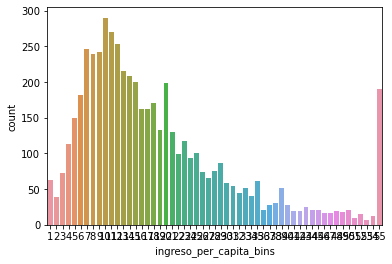

In [31]:
sns.countplot(survey_household_assigned_per_capita['ingreso_per_capita_bins'])

<AxesSubplot:xlabel='ingreso_per_capita_sin_qec_bins', ylabel='count'>

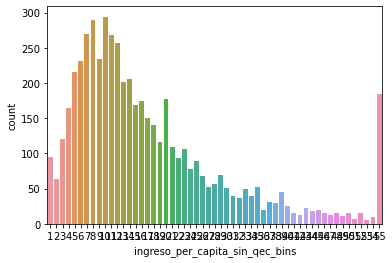

In [32]:
sns.countplot(survey_household_assigned_per_capita['ingreso_per_capita_sin_qec_bins'])

In [33]:
"""
En Covid bajo la lupa, para junio 2020 se reportan los siguientes valores de pobreza extrema y pobreza general:
* pobreza extrema - 8.2 %
* pobreza general - 34.6 %
"""
get_percentage_table_with_expansion_factor(survey_household_assigned_per_capita, 'pobreza_sin_subsidio', 'factor_expansion_first')

,exp_count,percentage
pobreza_sin_subsidio,,
0,2.165058e+06,63.504728
1,8.560887e+05,25.110499
2,3.881395e+05,11.384773


In [34]:
"""
En Covid bajo la lupa, para junio 2020 se reportan los siguientes valores de pobreza extrema y pobreza general
gracias a los programas de mitigación:
* pobreza extrema - 5.1 %
* pobreza general - 27.4 %
"""
get_percentage_table_with_expansion_factor(survey_household_assigned_per_capita, 'pobreza', 'factor_expansion_first')

,exp_count,percentage
pobreza,,
0,2.427868e+06,71.213394
1,7.635013e+05,22.394758
2,2.179164e+05,6.391848


In [35]:
get_percentage_table_with_expansion_factor(survey_household_assigned_per_capita, 'pobreza_sin_qec', 'factor_expansion_first')

,exp_count,percentage
pobreza_sin_qec,,
0,2.225993e+06,65.292058
1,8.393900e+05,24.620698
2,3.439030e+05,10.087244


# Pipeline

In [36]:
survey_pipeline_processor = make_pipeline(
    replace_member_transformer,
    assign_member_transformer,
    aggregate_member_transformer,
    merge_survey_household_member_transformer,
    household_replace_transformer,
    select_household_transformer,
    assign_household_transformer
)

survey_final_processed = survey_pipeline_processor.transform(survey_member_raw)

In [37]:
survey_final_processed['ingreso_per_capita_sin_qec_bins'].isna().sum()

0

# Processing to Criteria

## Replace Transformer

In [44]:
replace_final_map = {
    'sexo_jefe_familia_sum': {
        0: 'Hombre',
        1: 'Mujer',
    },
    'ps_comer_es_primero': {
        1: 'Beneficiario CEP',
        2: 'No Beneficiario CEP'
    },
    'recibe_qec': {
        True: 'Beneficiario QEC',
        False: 'No Beneficiario QEC'
    },
    'zona_first': {
        0: 'Urbana',
        1: 'Rural'
    },
    'edad_menor_5_any': {
        True: 'Con menores de 5 años',
        False: 'Sin menores de 5 años'
    },
    'edad_mayor_60_any': {
        True: 'Con mayores de 60 años',
        False: 'Sin mayores de 60 años'
    },
    'edad_mayor_65_any': {
        True: 'Con mayores de 65 años',
        False: 'Sin mayores de 65 años'
    },
    'edad_5_a_10_any': {
        True: 'Con niños de 5 a 10 años',
        False: 'Sin niños de 5 a 10 años'
    },
    'edad_10_a_15_any': {
        True: 'Con niños de 10 a 15 años',
        False: 'Sin niños de 10 a 15 años'
    },
    'es_trabajador_domestico_any': {
        True: 'Con trabajador doméstico',
        False: 'Sin trabajador doméstico'
    },
    'es_informal_any': {
        True: 'Con trabajador informal',
        False: 'Sin trabajador informal'
    },
    'tipo_hogar':{
        'Unipersonal': 'Unipers./Pareja sin hijos',
        'Nuclear sin hijos': 'Unipers./Pareja sin hijos',
        'Nuclear con hijos': 'Nuclear',
        'Nuclear monoparental': 'Monoparental no extendido',
        'Extendido base nuclear sin hijos': 'Extendido',
        'Extendido base nuclear con hijos': 'Extendido',
        'Extendido base monoparental': 'Extendido',
        'Extendido sin base nuclear': 'Extendido',
        'Compuesto': 'Compuesto',
    },
    'informalidad_mayoria': {
        True: 'Mayoría empleo informal',
        False: 'Minoría empleo informal'
    },
    'es_trabajador_infantil_any': {
        True: 'Con trabajo infantil',
        False: 'Sin trabajo infantil'
    }
}

replace_final_transformer = ReplaceTransformer(replace_final_map)
survey_final_replaced = replace_final_transformer.transform(survey_final_processed)

## Name Transformer

In [45]:
name_final_map = {
    'id_hogar': 'uid',
    'factor_expansion_first': 'weight',
    # Segmentation
    'zona_first': 'Zona Urbano-Rural',
    'ps_comer_es_primero': 'Beneficiario de Comer es Primero',
    'recibe_qec': 'Beneficiario de Quédate en Casa',
    'sexo_jefe_familia_sum': 'Sexo jefe de familia',
    'grupo_region': 'Macroregión geográfica',
    'region': 'Región geográfica',
    'tipo_hogar': 'Tipo familia',
    'edad_menor_5_any': 'Miembro menor de 5 años',
    'edad_mayor_60_any': 'Miembro mayor de 60 años',
    'edad_5_a_10_any': 'Miembro entre 5 y 10 años',
    'edad_10_a_15_any': 'Miembro entre 10 y 15 años',
    'edad_mayor_65_any': 'Miembro mayor de 65 años',
    'es_trabajador_domestico_any': 'Miembro trabajador doméstico',
    'es_informal_any': 'Miembro con empleo informal',
    'informalidad_mayoria': 'Mayoría de miembros con empleo informal',
    # Statistics
    'edad_menor_5_sum': 'stat_edad_menor_5_count',
    'edad_mayor_60_sum': 'stat_edad_mayor_60_count',
    'cantidad_miembros_hogar_first': 'stat_miembros_hogar_count',
    'beneficio_promedio_qec': 'stat_beneficio_promedio_qec',
    # Factors
    'factor_cost': '(C) Beneficio en DOP',
    'factor_cost_percent': '(C) Beneficio en % del monto de QEC',
    'factor_impact': '(I) Beneficio en DOP',
    'factor_impact_dop': '(I) Beneficio en DOP (miembros)',
    'factor_impact_percent': '(I) Beneficio en % del monto de QEC',
    # Prioritization
    'ingreso_per_capita_sin_qec_bins': 'Ingreso del hogar antes de recibir QEC',
}

name_final_transformer = NameTransformer(name_final_map, keep_features=[])
survey_final_named = name_final_transformer.transform(survey_final_replaced)

In [46]:
cdisplay(survey_final_named.head())

,uid,weight,Zona Urbano-Rural,Beneficiario de Comer es Primero,Beneficiario de Quédate en Casa,Sexo jefe de familia,Macroregión geográfica,Región geográfica,Tipo familia,Miembro menor de 5 años,Miembro mayor de 60 años,Miembro entre 5 y 10 años,Miembro entre 10 y 15 años,Miembro mayor de 65 años,Miembro trabajador doméstico,Miembro con empleo informal,Mayoría de miembros con empleo informal,stat_edad_menor_5_count,stat_edad_mayor_60_count,stat_miembros_hogar_count,stat_beneficio_promedio_qec,(C) Beneficio en DOP,(C) Beneficio en % del monto de QEC,(I) Beneficio en DOP,(I) Beneficio en DOP (miembros),(I) Beneficio en % del monto de QEC,Ingreso del hogar antes de recibir QEC
0,1007,654.403718,Urbana,No Beneficiario CEP,No Beneficiario QEC,Hombre,Gran Santo Domingo,Región Ozama,Unipers./Pareja sin hijos,Sin menores de 5 años,Sin mayores de 60 años,Sin niños de 5 a 10 años,Sin niños de 10 a 15 años,Sin mayores de 65 años,Sin trabajador doméstico,Sin trabajador informal,Minoría empleo informal,0,0,1,0.0,1.0,0.0,0.001904,0.001904,0.0,55
1,2006,654.403718,Urbana,No Beneficiario CEP,No Beneficiario QEC,Mujer,Gran Santo Domingo,Región Ozama,Nuclear,Sin menores de 5 años,Con mayores de 60 años,Sin niños de 5 a 10 años,Sin niños de 10 a 15 años,Sin mayores de 65 años,Sin trabajador doméstico,Sin trabajador informal,Minoría empleo informal,0,1,3,0.0,1.0,0.0,0.001904,0.000635,0.0,29
2,3008,654.403718,Urbana,Beneficiario CEP,No Beneficiario QEC,Mujer,Gran Santo Domingo,Región Ozama,Monoparental no extendido,Sin menores de 5 años,Sin mayores de 60 años,Sin niños de 5 a 10 años,Sin niños de 10 a 15 años,Sin mayores de 65 años,Sin trabajador doméstico,Con trabajador informal,Mayoría empleo informal,0,0,3,0.0,1.0,0.0,0.001904,0.000635,0.0,10
3,6006,654.403718,Urbana,Beneficiario CEP,No Beneficiario QEC,Hombre,Gran Santo Domingo,Región Ozama,Nuclear,Sin menores de 5 años,Sin mayores de 60 años,Con niños de 5 a 10 años,Con niños de 10 a 15 años,Sin mayores de 65 años,Sin trabajador doméstico,Con trabajador informal,Mayoría empleo informal,0,0,5,0.0,1.0,0.0,0.001904,0.000381,0.0,4
4,7006,654.403718,Urbana,No Beneficiario CEP,No Beneficiario QEC,Mujer,Gran Santo Domingo,Región Ozama,Extendido,Con menores de 5 años,Sin mayores de 60 años,Sin niños de 5 a 10 años,Sin niños de 10 a 15 años,Sin mayores de 65 años,Sin trabajador doméstico,Con trabajador informal,Mayoría empleo informal,1,0,4,0.0,1.0,0.0,0.001904,0.000476,0.0,2


# Export file

In [ ]:
survey_final_named.to_csv(
    f"QEC_escenario_s11.csv", 
    index=False
)